# Setup

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn

import torch.nn.functional as F
from torchvision import transforms, datasets
import torch.optim as optim
import pandas as pd

# Organize testing and training data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
all = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/novel_passive_session_990464099_excitatory.csv')
adp_trial = all[all.repeat_number.notnull()]

neuron_ids = filter(lambda str: str.isnumeric(), adp_trial.columns.to_list())
neuron_ids = [neuron for neuron in neuron_ids]
features = adp_trial[neuron_ids]
ncell = len(neuron_ids)

In [ ]:
# full_X = features
# full_y = adp_trial.image_index

# unadapted_X = features[adp_trial.repeat_number == 0]
# unadapted_y = adp_trial[adp_trial.repeat_number == 0].image_index

# adapted_X = features[adp_trial.repeat_number == 1]
# adapted_y = adp_trial[adp_trial.repeat_number == 1].image_index

# n_un = len(unadapted_y)
# n_ad = len(adapted_y)
# assert n_ad < n_un
# print([full_X.shape, full_y.shape, unadapted_X.shape, unadapted_y.shape, adapted_X.shape, adapted_y.shape])

In [ ]:
# adapted_X_n = adapted_X.reset_index()
# adapted_y_n = adapted_y.reset_index()

# balance = np.array([0,100])
# samplesArray = unadapted_X.index.to_numpy()
# while (balance.max() - balance.min() > 4):
#   np.random.shuffle(samplesArray); np.random.shuffle(samplesArray); np.random.shuffle(samplesArray)
#   unadapted_X_n = unadapted_X.loc[samplesArray[:n_ad]].reset_index()
#   unadapted_y_n = unadapted_y.loc[samplesArray[:n_ad]].reset_index()
#   balance = unadapted_y_n.image_index.value_counts().to_numpy()

# balance = np.array([0,100]); balance2 = balance
# samplesArray = full_X.index.to_numpy()
# while (balance.max() - balance.min() > 4) or (balance2.max() - balance2.min() > 8):
#   np.random.shuffle(samplesArray); np.random.shuffle(samplesArray); np.random.shuffle(samplesArray)
#   full_X_n = full_X.loc[samplesArray[:n_ad]].reset_index()
#   full_y_n = full_y.loc[samplesArray[:n_ad]].reset_index()
#   balance = full_y_n.image_index.value_counts().to_numpy()
#   balance2 = adp_trial.loc[samplesArray[:n_ad]].repeat_number.value_counts()
  
# print(unadapted_y_n.image_index.value_counts())
# print(full_y_n.image_index.value_counts())
# print(adp_trial.loc[samplesArray[:n_ad]].repeat_number.value_counts())

In [ ]:
# import time
# time.sleep(3600*3)

In [ ]:
df_full = adp_trial.sample(frac=0.5, replace=False, random_state=42) # sample half of full data
df_unadapted = adp_trial[adp_trial.repeat_number==0]
df_adapted = adp_trial[adp_trial.repeat_number==1]
len(df_full), len(df_unadapted), len(df_adapted)

(350, 356, 343)

## full

In [ ]:
# df = df_full
# df = df_unadapted
df = df_adapted

########### Parameters
nFold = 10
samplesArray = np.asarray(range(0, len(df)))
np.random.shuffle(samplesArray)

########### Testing Set
nTestEntries = np.int(np.floor(len(df)/ nFold) + (len(df) % nFold))
testing_set_entries = samplesArray[:nTestEntries]
testing_set = df.iloc[testing_set_entries]
samplesArray = samplesArray[nTestEntries:]

########### Testing Set
training_set = df.iloc[samplesArray]
    
print('Entries in')
print('  Testing Set: ' + str(len(testing_set)))
print('  Each Training Set: ' + str(len(training_set)))

# Thing to predict
y_category = 'image_index'

X_training = np.asarray(training_set[neuron_ids])
y_training = np.asarray(training_set[y_category])
X_testing = np.asarray(testing_set[neuron_ids])
y_testing = np.asarray(testing_set[y_category])

Entries in
  Testing Set: 37
  Each Training Set: 306


In [ ]:
# Network Structure and Hyperparameters

class Net(nn.Module):
    
    # This function defines the different layers in our model
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(ncell, ncell) # ncell is the number of neurons in the session i'm using
        self.fc2 = nn.Linear(ncell, ncell) # hidden layer
        self.fc3 = nn.Linear(ncell, 8) # number of unique image index
        
    # this function 'passes' our data through the different layers (and a relu function)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

net = Net()


########## Hyperparameters
loss_function = nn.CrossEntropyLoss()

# The thing that adjusts the models adjustable parameters (like weights) (Adam: adaptive momentum)
optimizer = optim.Adam(net.parameters(), lr=.0001)

# How many times to show network all of the data. I think somewhere between 3 to 10 is normal?
epoch_num = 20

# Batch size for the dataset. I'm not sure what's normal here. I think it depends on your VRAM size
batch_size = 30


########## Run some random data through network to make sure it works.
X = torch.randn(ncell)
X = X.view(-1,ncell)
print(net(X))


tensor([[-2.1695, -2.2546, -1.9857, -1.9939, -1.9341, -2.1542, -2.1562, -2.0319]],
       grad_fn=<LogSoftmaxBackward>)


In [ ]:
# Train the model
# n_epoch full passes over the data
for epoch in range(epoch_num):
    
    for batch_num in range(batch_size):  
        
        # X is the batch of features, y is the batch of targets.
        X = X_training[batch_num*batch_size:batch_num*batch_size + batch_size] 
        y = y_training[batch_num*batch_size:batch_num*batch_size + batch_size] 
        
        # convert from numpy array to torch data type
        X = torch.from_numpy(X)
        y = torch.from_numpy(y)
        
        X = X.float()
        
        # sets gradients to 0 before loss calc. You will do this likely every step.
        net.zero_grad()  
        
         # pass in the reshaped batch
        output = net(X) 
        
         # calc and grab the loss value
        loss = F.nll_loss(output, y) 
        
        # apply this loss backwards thru the network's parameters
        loss.backward()  
        
        # attempt to optimize weights to account for loss/gradients
        optimizer.step()
        
    # print loss. We hope loss (a measure of wrong-ness) declines! 
    print(loss)  

tensor(nan, grad_fn=<NllLossBackward>)
tensor(nan, grad_fn=<NllLossBackward>)
tensor(nan, grad_fn=<NllLossBackward>)
tensor(nan, grad_fn=<NllLossBackward>)
tensor(nan, grad_fn=<NllLossBackward>)
tensor(nan, grad_fn=<NllLossBackward>)
tensor(nan, grad_fn=<NllLossBackward>)
tensor(nan, grad_fn=<NllLossBackward>)
tensor(nan, grad_fn=<NllLossBackward>)
tensor(nan, grad_fn=<NllLossBackward>)
tensor(nan, grad_fn=<NllLossBackward>)
tensor(nan, grad_fn=<NllLossBackward>)
tensor(nan, grad_fn=<NllLossBackward>)
tensor(nan, grad_fn=<NllLossBackward>)
tensor(nan, grad_fn=<NllLossBackward>)
tensor(nan, grad_fn=<NllLossBackward>)
tensor(nan, grad_fn=<NllLossBackward>)
tensor(nan, grad_fn=<NllLossBackward>)
tensor(nan, grad_fn=<NllLossBackward>)
tensor(nan, grad_fn=<NllLossBackward>)


In [ ]:
# Score Training Set Performance
correct = 0
total = 0

with torch.no_grad():
    for batch_num in range(batch_size):  
        
         # X is the batch of features, y is the batch of targets.
        X = X_training[batch_num*batch_size:batch_num*batch_size + batch_size] 
        y = y_training[batch_num*batch_size:batch_num*batch_size + batch_size] 
        
        # convert from numpy array to torch data type
        X = torch.from_numpy(X)
        y = torch.from_numpy(y)
        
        X = X.float()
        
        output = net(X)
        
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1

print("Training Set Accuracy: ", round(correct/total, 3))

Training Set Accuracy:  0.987


In [ ]:
# Score Test Set Performance
correct = 0
total = 0

with torch.no_grad():
    for batch_num in range(batch_size):  
        
         # X is the batch of features, y is the batch of targets.
        X = X_testing[batch_num*batch_size:batch_num*batch_size + batch_size] 
        y = y_testing[batch_num*batch_size:batch_num*batch_size + batch_size] 
        
        # convert from numpy array to torch data type
        X = torch.from_numpy(X)
        y = torch.from_numpy(y)
        
        X = X.float()
        
        output = net(X)
        
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1

print("Test Set Accuracy: ", round(correct/total, 3))

Test Set Accuracy:  0.865


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

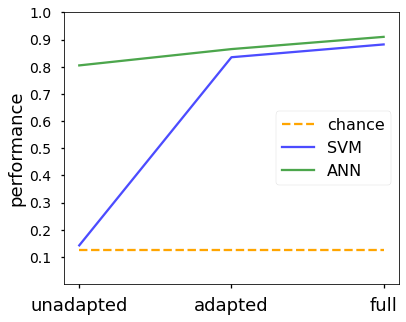

In [ ]:
# full 0.91
# unadapted 0.805
# adapted 0.865

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score
import sklearn as skl
from sklearn.datasets import load_boston
from sklearn.linear_model import ElasticNet, ElasticNetCV, Ridge, Lasso, LinearRegression, SGDClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.base import clone
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

import random
import warnings
import time
from scipy.signal import savgol_filter

x = np.arange(3)
y = [0.1428559249786871, 0.8350298380221653, 0.8821142369991474] #, 0.12419825072886297, 0.12332361516034987]
yNL = [0.805, 0.865, 0.91];
yerr = [0.0021487, 0.00239572, 0.00157882] #, 0.00789221, 0.00154821] # for SVM errorbar

plt.style.use('seaborn-talk')
plt.figure(figsize=(6,5))
plt.errorbar(x, y, yerr=None, alpha=0.7, color='b', label='SVM')
plt.errorbar(x, yNL, yerr=None, alpha=0.7, color='g', label='ANN')
plt.hlines(y=0.125, xmin=0, xmax=2, linestyles='--', colors='orange', label='chance')
# plt.legend(fontsize=14, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend(loc='center right', fontsize=16)
figtitle = 'SVM and ANN decoder trained by (un)adapted response'
# plt.title(figtitle, fontsize=16, pad=15)

labels = ['unadapted', 'adapted', 'full'] #, 'U-A', 'A-U'];
plt.xticks(x, labels, rotation=0, fontsize=18);
plt.ylim(-0,1);
plt.yticks(np.arange(0.1,1.01,0.1), fontsize=14)
# plt.grid(axis = 'y')
plt.ylabel("performance", fontsize=18);
# plt.tight_layout()

plt.savefig(figtitle + '.pdf', format='pdf')
from google.colab import files
files.download(figtitle + '.pdf')